#<u>**D606 Data Science Capstone**</u>  

## Detecting Anomalous SEC Filings to Identify Financial Risk  


Bernard Connelly  
Master of Science, Data Analytics, Western Governors University  
Dr. Daniel Smith

---

In [3]:
# Packages
import numpy as np # Numerical operations and array manipulation
import pandas as pd # Dataframes & Loading data
import matplotlib.pyplot as plt # Visualization
import seaborn as sns # Visualization Alternatives
import zipfile # Managing Zip files
import os
import warnings # Squench warnings
warnings.filterwarnings('ignore')
from sklearn.impute import SimpleImputer # Imputing NaN values
from sklearn.ensemble import IsolationForest # Isolation Forest
from scipy.stats import chi2_contingency # Chi-Square test

BLOCK_CELL = False # Creating a toggle to prevent long code blocks from running

# **A: Research Question**  

This project seeks to answer <i>"Can unsupervised machine learning identify anomalous patterns in standardized financial filings that may indicate potential financial irregularity, risk exposure, or reporting inconsistencies?"</i>

The financial collapse of firms often stems from deteriorating fundamental details that may go unnoticed in time-series data, but appear clearly when compared to peer benchmarks. With the increasing availability of structured financial data from the SEC, it is now possible to apply machine learning techniques to detect outliers across balance sheet and income statement metrics. This project will use Isolation Forests to flag anomalous SEC filings that warrant deeper scrutiny. These anomalies could represent aggressive accounting, earnings manipulation, financial instability, or sector outliers — insights useful for regulators, investors, and analysts.

The financial industry has overlapping regulations to ensure individual firms are engaging in fair practices and maintaining high integrity in their business with clients. Firms engaging in deceptive or overly aggressive tactics to gain a competitive advantage are identified and fined, sanctioned, or shut down based on maintaining a fair market. Using unsupervised machine learning, the project will seek to identify trends or similarities between firms that fail as a form of early identification of these deceptive practices.

The data used comes from XBRL-tagged 10-K statements, which are available every quarter and, as a result, are present in a well-structured data model. Additionally, unsupervised machine learning is an effective method for these filings, as there are no labels for "fraudulent" or "at-risk" firms in the dataset, so supervised methods such as logistic regression or classification trees are ineffective in this scenario. The Isolation Forest method is based upon the principle that anomalies are few and different, and seeks to isolate outliers by selecting random features and splitting values actively. It is highly efficient for large datasets and performs well with high-dimensional numerical data such as financial ratios or metrics.

The null hypothesis in this scenario is that no statistically detectable anomaly pattern in financial filings differentiates high-risk or irregular companies from their peers. This makes the alternate hypothesis that statistically detectable anomalies exist in certain financial filings, Indicating outliers in financial reporting that may reflect financial risk or irregularities. Suppose the alternate hypothesis proves to be accurate. In that case, regulators and compliance teams may be able to detect risk and financial irregularity by actively analyzing publicly available filings submitted by financial firms.


________________________

# **B: Data Collection**  
As noted above, this data was made publicly available via the Securities and Exchange Commission (SEC) website. The files are posted on a quarterly basis, with the most recent filing available from Q1 2025. For the purposes of this project, all quarters between Q1 2022 and Q1 2025 were selected, providing over three years of data for review.

Each quarterly dataset is stored as a `.zip file`, which contains several `.txt` files representing different aspects of company filings:

- `num.txt`: Financial data (e.g., assets, liabilities, revenues)
- `sub.txt`: Submission metadata (e.g., company name, form type, filing period)
- `tag.txt`: Taxonomy tags defined by the EDGAR framework
- `pre.txt`: Statement presentation data, with one row for each line item as tagged by the filer

The filings are further categorized by form type, such as standard annual reports and amendments. This project focuses specifically on 10-K filings, which are annual reports submitted at the end of a company's fiscal year. These filings offer a comprehensive overview of financial performance and operations and are among the most standardized and complete records available.

Since the data is publicly available, collection was straightforward. Each `.zip` file was downloaded directly from the SEC’s Market Data section, then uploaded to Google Drive for integration into Google Colab.

The primary advantage of using this data is its consistency and structure. As official filings submitted to a financial regulator, the data adheres to strict formatting requirements and is validated for accuracy. Each file follows the same schema quarter-over-quarter and reflects standardized XBRL reporting — making it well-suited for machine learning applications.

However, there are some challenges. The dataset’s complexity stems from its multi-file structure and the need to join datasets across different dimensions (e.g., metadata, financials, taxonomy). Preprocessing requires domain knowledge of SEC reporting and XBRL conventions. Additionally, aligning data across quarters and filtering for valid 10-K submissions involves multiple manual and programmatic steps, increasing the risk of inconsistency. These steps — including how the datasets were combined, reshaped, and filtered — are outlined in Section C below.

#**C: Data Extraction and Preparation**

## <u>Runtime Optimization</u>
Due to the substantial size of the SEC datasets, which contain significantly more data than required to address the research question, loading and processing the files in their entirety proved cumbersome. Each time the runtime reset, it took over five minutes to load the full dataset into memory, creating unnecessary delays during development and testing.

To streamline the process, early filtering steps were introduced to limit the dataset to:
- Filings starting from 2022 onward, and
- Only annual 10-K filings, excluding quarterly filings.

Annual reports provide a complete and consistent summary of a company’s financial position and are sufficient for building an unsupervised machine learning model. Additionally, including quarterly filings would have drastically increased runtime and complexity, without providing proportionate analytical value for the scope of this project.

To preserve efficiency in subsequent development, the cleaned subset was saved to a `.pkl` (pickle) file. This file can be loaded instantly in future sessions, bypassing the need to re-import and reprocess the raw data each time.

Finally, a custom toggle variable named `BLOCK_CELL` was introduced to allow code blocks to be easily excluded from execution while remaining visible for reference. This mechanism ensured that heavy-loading operations, such as initial extraction and reshaping, were not repeatedly triggered during later stages of analysis.

## <u>Loading, Extracting and Concatenating</u>  
For the purposes of this project, I needed to use the `num.txt` and `sub.txt` data, so the first step was to extract these files and load them. This was accomplished using a loop which iteratively opened each zip file, extracted the num and sub data into their own lists, and appended each with the source quarter for reference. Finally, after all files were loaded, they were each contcatenated into their own dataframes.

In [4]:
if BLOCK_CELL:
  # Defining Folder with files & Initializing Dataframes
  zip_folder = '/content/drive/MyDrive/Colab_Notebooks/Data Files/'
  all_files = os.listdir(zip_folder)
  zip_files_to_process = [f for f in all_files if f.endswith('.zip')]

  all_num = []
  all_sub = []

  for zip_file in zip_files_to_process:
      try:
        with zipfile.ZipFile(os.path.join(zip_folder, zip_file), 'r') as zip_ref:
            zip_ref.extractall('temp_data')

        ## Defining specific files to import
        num = pd.read_csv('temp_data/num.txt', sep='\t', low_memory=False)
        sub = pd.read_csv('temp_data/sub.txt', sep='\t', low_memory=False)

        ## Tagging each with the source quarter
        num['source_file'] = zip_file
        sub['source_file'] = zip_file

        all_num.append(num)
        all_sub.append(sub)
      except Exception as e:
          print(f"Failed on {zip_file}: {e}")

  # Combining into one dataframe
  num_full = pd.concat(all_num, ignore_index=True)
  sub_full = pd.concat(all_sub, ignore_index=True)


## <u> Filtering and Feature Selection </u>  
As described above, a subset of the full DataFrame was created using only annual 10-K filings, and further narrowed to filings from 2022 onward. This allowed for analysis of the most recent and consistent financial data.

Once the dataset was limited to relevant periods and filing types, the next step in preparation involved selecting key financial features (referred to as tags in the SEC data structure) that would be used to create calculated ratios and derived variables for training the Isolation Forest model. Some of these tags include income statement and balance sheet metrics such as `Assets`, `Liabilities`, `Revenues`, and `NetIncomeLoss`. These were chosen based on their ability to reflect a company's financial health and their usefulness in generating the aforementioned ratios.

This filtering reduced the dataset to only the fields necessary for modeling and anomaly detection. Each of the selected tags was later transformed into either a direct feature or a derived ratio used in the model.

In [5]:
if BLOCK_CELL:
  # Narrowing scope of dataset for readability and accuracy
  sub_10k = sub_full[sub_full['form'] == '10-K']
  sub_recent = sub_10k[sub_10k['period'] >= 20220101]

  # Defining core financial tags
  target_tags = [
          'Assets', 'Liabilities', 'StockholdersEquity', 'NetIncomeLoss',
      'Revenues', 'OperatingIncomeLoss', 'AssetsCurrent', 'LiabilitiesCurrent',
      'CashAndCashEquivalentsAtCarryingValue', 'RetainedEarningsAccumulatedDeficit',
      'GrossProfit', 'LongTermDebt'
  ]

  # Keeping only relevant filings & tags
  num_reduce = num_full[
      (num_full['adsh'].isin(sub_recent['adsh'])) &
      (num_full['tag'].isin(target_tags))
  ]

## <u> Pivot and Metadata </u>  
The final step in extraction and initial preparation was to transform the dataset so each row is one filing, and each column is one financial metric so it is a readable and usable format. Finally, I merged back in metadata from the `sub.txt` file.

In [6]:
if BLOCK_CELL:
  #Pivoting to wide format and merging
  pivoted = num_reduce.pivot_table(
      index='adsh', columns='tag', values='value', aggfunc='first'
  ).reset_index()

  # Adding company metadata
  financials_df = pivoted.merge(
      sub_recent[['adsh', 'name', 'cik', 'period']], on='adsh', how='left'
  )


## <u>Loading Data from Pickle File</u>  
The `BLOCK_CELL` Boolean Flag was flipped to true in the cell above to ensure subsequent cells can run without issue. The pickle file stored below represents the initial import and preparation of the datafile which will be used in analysis for this project.

In [7]:

if BLOCK_CELL:
  # Saving the slimmed-down dataset as a Pickle file for easier reading and loading
  financials_df.to_pickle('/content/drive/MyDrive/Colab_Notebooks/D606 - Capstone/financials_trimmed_2022.pkl')

BLOCK_CELL = True ## Enabling code below this block to run


In [8]:

# Loading the Pickle file
file_path = '/content/drive/MyDrive/Colab_Notebooks/D606 - Capstone/financials_trimmed_2022.pkl'
financials_df = pd.read_pickle(file_path)


## <u>Initial Data Profiling</u>  

Initial data profiling was performed in the clean code block below to assess the dataset before any transformations were applied. The original dataset contained 16 and 17224 rows, and fields with varying data types, including floats, integers, and Python objects.

A preliminary scan revealed that several fields contained substantial amounts of missing or null values. For example, `LongTermDebt` had only 1102 (6.4%) non-null entries, while `Revenues` had just 5433 (31.5%) responses out of a possible 17,224. These sparsely populated fields may reflect the very reporting inconsistencies or anomalies this project aims to uncover.


In [9]:
# Initial Profiling
print('\033[4m' + "Info:" + '\033[0m')
print(financials_df.info(), "\n")
print('\033[4m' + 'Shape:' + '\033[0m')
print(financials_df.shape, "\n")
print('\033[4m' + "Describe:" + '\033[0m')
print(financials_df.describe(),"\n")
print('\033[4m' + "Header:" + '\033[0m')
financials_df.head()

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17224 entries, 0 to 17223
Data columns (total 16 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   adsh                                   17224 non-null  object 
 1   Assets                                 17120 non-null  float64
 2   AssetsCurrent                          13552 non-null  float64
 3   CashAndCashEquivalentsAtCarryingValue  13618 non-null  float64
 4   GrossProfit                            6240 non-null   float64
 5   Liabilities                            15117 non-null  float64
 6   LiabilitiesCurrent                     13501 non-null  float64
 7   LongTermDebt                           1102 non-null   float64
 8   NetIncomeLoss                          16119 non-null  float64
 9   OperatingIncomeLoss                    13278 non-null  float64
 10  RetainedEarningsAccumulatedDeficit     16352 non-null  float64
 

,adsh,Assets,AssetsCurrent,CashAndCashEquivalentsAtCarryingValue,GrossProfit,Liabilities,LiabilitiesCurrent,LongTermDebt,NetIncomeLoss,OperatingIncomeLoss,RetainedEarningsAccumulatedDeficit,Revenues,StockholdersEquity,name,cik,period
0,0000002178-23-000038,3.841590e+08,2.501430e+08,9.782500e+07,NaN,214317000.0,2.310600e+08,NaN,3.487000e+06,15874000.0,7.296400e+07,0.0,1.490920e+08,"ADAMS RESOURCES & ENERGY, INC.",2178,20221231.0
1,0000002178-24-000035,2.158130e+08,2.324710e+08,3.325600e+07,NaN,290982000.0,2.107870e+08,NaN,3.487000e+06,17029000.0,7.066100e+07,323000.0,2.180200e+07,"ADAMS RESOURCES & ENERGY, INC.",2178,20231231.0
2,0000002488-23-000047,6.758000e+10,8.583000e+09,4.835000e+09,4.347000e+09,NaN,4.240000e+09,NaN,2.490000e+09,991000000.0,-1.310000e+08,NaN,-3.000000e+06,ADVANCED MICRO DEVICES INC,2488,20221231.0
3,0000002488-24-000012,6.758000e+10,1.676800e+10,3.933000e+09,1.046000e+10,NaN,6.689000e+09,NaN,8.540000e+08,401000000.0,-1.310000e+08,NaN,5.800500e+10,ADVANCED MICRO DEVICES INC,2488,20231231.0
4,0000002488-25-000012,6.788500e+10,1.676800e+10,3.933000e+09,1.272500e+10,NaN,6.689000e+09,NaN,1.320000e+09,401000000.0,2.364000e+09,NaN,-1.310000e+08,ADVANCED MICRO DEVICES INC,2488,20241231.0


## <u>Data Exploration and Cleaning</u>  

Given the nature of the financial data, the cleaning process was a critical step to ensure the dataset was properly prepared for unsupervised machine learning using the Isolation Forest algorithm.

Initial generic cleaning steps included renaming columns to follow Python naming conventions—specifically, converting all headers to lowercase and using underscores to separate words. Additionally, column names were stripped of any leading or trailing whitespace to prevent errors during analysis.

The dataset was also checked for duplicate filings by individual financial firms. Two duplicates were found, which appeared to be an amended filing submitted by the firm either due to significant changes in reported values or to correct errors in the original submission. The decision was made to retain the later (amended) filings, as they were assumed to be the most accurate and up-to-date versions.


In [10]:
# Formatting all columns to match naming conventions
financials_df.columns = financials_df.columns.str.replace(' ', '_')
financials_df = financials_df.rename(columns={
    'AssetsCurrent' : 'assets_current',
    ' CashAndCashEquivalentsAtCarryingValue' : 'cashandcashequivalentsatcarryingvalue', ## Variable too long to use underscores
    'GrossProfit' : 'gross_profit',
    'LiabilitiesCurrent': 'liabilities_current',
    'LongTermDebt' : 'long_term_debt',
    'NetIncomeLoss' : 'net_income_loss',
    'OperatingIncomeLoss' : 'operating_income_loss',
    'RetainedEarningsAccumulatedDeficit' : 'retained_earnings_accumulated_deficit',
    'StockholdersEquity' : 'stockholders_equity',
})
financials_df.columns = financials_df.columns.str.lower()

In [11]:
# Stripping Whitespace from Column Names
financials_df.columns = financials_df.columns.str.strip()

# Dropping Duplicate Rows
financials_df = financials_df.drop_duplicates()
print(f"Rows after duplicates removed: {financials_df.shape[0]}")

# Confirming one filing per firm per year
print(f"Duplicate/Amended filings per firm annually: {financials_df.duplicated(subset=['cik', 'period']).sum()}")

Rows after duplicates removed: 17224
Duplicate/Amended filings per firm annually: 2


### Duplicate Filings  
While no rows in the dataset were exact duplicates, two firms — TANGER INC and GPB HOLDINGS II, LP — each submitted multiple filings for the same reporting period. Upon inspection, these appear to represent amended submissions rather than errors in data ingestion. The differences between the filings suggest updates to key financial values, possibly reflecting corrections or finalized figures. To ensure the dataset retained the most accurate and current information, the later filings were preserved, and the earlier submissions were removed to prevent ambiguity or redundancy in the analysis.

In [12]:
# Duplicated/Amended Filing Details
financials_df[financials_df.duplicated(subset=['cik', 'period'], keep=False)]

,adsh,assets,assets_current,cashandcashequivalentsatcarryingvalue,gross_profit,liabilities,liabilities_current,long_term_debt,net_income_loss,operating_income_loss,retained_earnings_accumulated_deficit,revenues,stockholders_equity,name,cik,period
1941,0000899715-23-000044,2.217011e+09,NaN,NaN,NaN,1.703731e+09,NaN,297742000.0,85831000.0,NaN,NaN,88120000.0,491643000.0,"TANGER FACTORY OUTLET CENTERS, INC",899715,20221231.0
1942,0000899715-24-000044,2.217011e+09,NaN,NaN,NaN,1.703731e+09,NaN,348467000.0,85831000.0,NaN,NaN,442613000.0,491643000.0,TANGER INC.,899715,20221231.0
8604,0001410578-24-000340,5.322120e+08,5763000.0,33038000.0,NaN,6.240700e+07,3032000.0,NaN,811000.0,-31594000.0,NaN,NaN,NaN,"GPB HOLDINGS II, LP",1640265,20231231.0
8720,0001410578-25-000502,5.169250e+08,NaN,10891000.0,NaN,2.842100e+07,NaN,NaN,1137000.0,-35233000.0,NaN,NaN,NaN,"GPB HOLDINGS II, LP",1640265,20231231.0


In [13]:
# Selecting only most recent filing
financials_df = financials_df.sort_values('adsh').drop_duplicates(subset=['cik', 'period'], keep='last')


## <u> Initial Sanity Check </u>
After handling the amended filing, the next step was to perform a general sanity test on the numbers to identify if anything was awry.  Evidence of irregularities are evidenced in the data, which means this project has details for the machine learning model to flag and assess. Examples below:
- Negative `Assets`: Some companies reported total assets as less than zero, which is atypical for balance sheets.
- Negative `Liabilities` and `Current Liabilities`: These values are expected to be positive; negative values may reflect reporting quirks or reversals.
- Negative `Revenues`: A small number of firms reported negative revenue, which is rare and could indicate extreme returns or restatements.
- Extreme values in financial ratios:
 - Equity Ratio exceeds 1.5 million in some cases.
 - Debt-to-Equity values range up to 180 million.
 - Profit Margin exceeds 30,000% for certain firms.

Some of the results are above are expected with a dataset that has so much variety in the firms filing. Extreme values can easily be identified by very large firms being in the same data as small firms - as future calculations would have very small or very large denominators in their calculations, yielding unsusual ratios.

In [14]:
# Sanity Check on Numeric Columns
financials_df.describe().T.sort_values('min').head(19)


,count,mean,std,min,25%,50%,75%,max
assets,17118.0,6.110817e+09,5.353242e+10,-1.062600e+11,33645500.0,322631000.0,1.983469e+09,3.844092e+12
stockholders_equity,15968.0,1.439667e+09,1.101955e+10,-1.054150e+11,-102400.0,5830735.5,4.023595e+08,7.437380e+11
revenues,5432.0,2.004302e+09,1.569984e+10,-9.086700e+10,635625.0,28745000.0,5.194032e+08,6.112890e+11
retained_earnings_accumulated_deficit,16352.0,1.490619e+09,1.330434e+10,-8.593400e+10,-183425043.0,-8609964.0,2.119528e+08,5.116020e+11
operating_income_loss,13277.0,2.400958e+08,1.849087e+09,-2.109200e+10,-25399000.0,-804225.0,5.491200e+07,8.269900e+10
net_income_loss,16117.0,2.632701e+08,2.481418e+09,-1.672000e+10,-17104000.0,0.0,5.391984e+07,9.699500e+10
liabilities,15115.0,5.635474e+09,8.022829e+10,-1.048300e+10,9343320.5,112680000.0,1.240570e+09,4.255074e+12
liabilities_current,13500.0,1.251561e+09,6.763526e+09,-5.721000e+09,5138869.5,47419500.0,3.999170e+08,1.977141e+11
gross_profit,6240.0,9.650876e+08,5.783399e+09,-3.123000e+09,2488962.0,61092500.0,4.712250e+08,1.707820e+11
assets_current,13551.0,1.592958e+09,7.595522e+09,-2.811000e+08,8477664.5,138586000.0,7.482450e+08,2.034665e+11


Similar to the extreme values, the presence of variables that are empty in the filings can demonstrate key details we need the model to identify. The code block below identifies what percentage of the values are blank. In order to properly train the model, I created flags to identify blank or missing values to assist in training.

In [15]:
# Checking for percentage of values which are missing
financials_df.isnull().mean().sort_values(ascending=False).head(13)

,0
long_term_debt,0.936070
revenues,0.684589
gross_profit,0.637673
operating_income_loss,0.229067
liabilities_current,0.216119
assets_current,0.213158
cashandcashequivalentsatcarryingvalue,0.209325
liabilities,0.122344
stockholders_equity,0.072814
net_income_loss,0.064162


## <u>Creating Flags to Assist with Model Training</u>  
The following code adds flags to the dataframe that assist the Isolation Forest model by highlighting observations that deviate from normal reporting patterns. This is important because Isolation Forests are sensitive to unusual or rare data points. The binary flags provide an explicit signal to the model, improving its ability to learn which patterns indicate anomaly or risk.

The following flags were created:

- <b>Likely Distressed Firms:</b> A flag (likely_distressed) was created for firms where assets, revenues, and stockholders_equity are all negative or missing. This combination suggests the firm may be in significant financial distress, and identifying them may be useful in detecting legitimate risk-based anomalies.

- <b>Likely Data Error:</b> A flag (likely_data_error) was created where assets are negative while stockholders_equity is strongly positive (greater than $100 million). This is a highly unusual combination and may indicate a data entry error, making it important to alert the model to these cases rather than treating them as normal.

- <b>Negative Assets:</b> A binary flag (negative_assets_flag) was created to mark firms with negative total assets. While rare, this condition may occur in distressed firms or due to reporting anomalies, so flagging it allows the model to assign it appropriate importance.

- <b>Missing Values:</b> For each core feature, a binary flag ({feature}_missing) was created to indicate whether the value was missing. This serves two purposes:
 - Isolation Forests do not accept missing values directly, so imputation is required.
 - Flagging missingness before imputation preserves this information for the model, enabling it to treat missingness itself as a potential anomaly signal.

In [16]:
# Creating a Negative Assets Flag
financials_df['negative_assets_flag'] = (financials_df['assets'] < 0).astype(int)

# Creating a likely data error flag
## Assets are negative but equity is strongly positive
financials_df['likely_data_error'] = ((financials_df['assets'] < 0) &
                                      (financials_df['stockholders_equity'] > 100_000_000)).astype(int)

# Creating a firm likely in distress flag
## Assets, Equity & Revenue are all negative or missing
financials_df['likely_distressed'] = (
    (financials_df['assets'] < 0) &
    (financials_df['stockholders_equity'] < 0) &
    (financials_df['revenues'].isna() | (financials_df['revenues'] < 0))
).astype(int)

# Creating Binary Columns for missing Values
for col in [
    'long_term_debt',
    'revenues',
    'gross_profit',
    'stockholders_equity',
    'assets',
    'net_income_loss',
    'cashandcashequivalentsatcarryingvalue',
    'assets_current',
    'liabilities_current',
    'retained_earnings_accumulated_deficit',
    'operating_income_loss'
]:
    financials_df[f'{col}_missing'] = financials_df[col].isna().astype(int)

Below is a plot to demonstrate the frequency of each new flag created above. These flags represent a smaller percentage of the dataset - shy of 3%, but are relevant to flag so the model can detect anomalies more effectively.

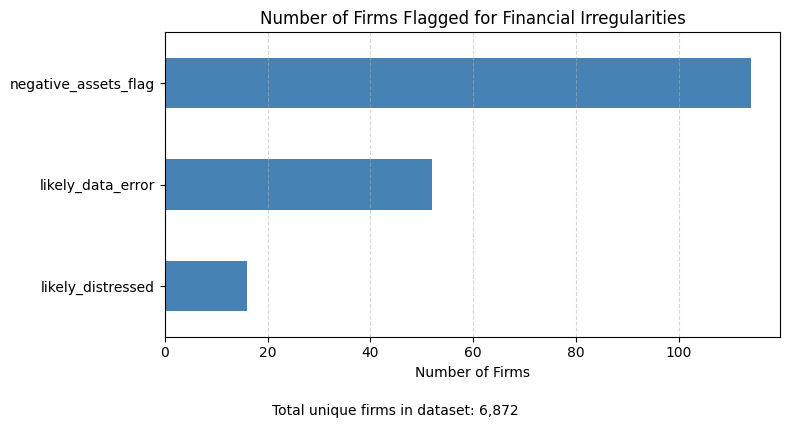

In [34]:
# Plotting frequencies of firm health flags
flags = ['negative_assets_flag', 'likely_data_error', 'likely_distressed']

## Count how many firms are flagged & total number of firms
flag_counts = financials_df[flags].sum().sort_values()
total_firms = financials_df['cik'].nunique()

# Plotting
plt.figure(figsize=(8, 4))
flag_counts.plot(kind='barh', color='steelblue')
plt.title('Number of Firms Flagged for Financial Irregularities')
plt.xlabel('Number of Firms')
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Add total firms note at the bottom
plt.figtext(0.5, -0.05, f'Total unique firms in dataset: {total_firms:,}',
            wrap=True, horizontalalignment='center', fontsize=10)

plt.tight_layout()
plt.show()


## <u>Dropout Flag Creation</u>  

Dropout Flag Creation
To support the analysis of anomalous financial reporting, a custom binary variable (dropped_in_2024) was created to identify firms that were present in the 2022 and/or 2023 dataset but no longer appeared in 2024.

This "dropout" flag acts as a proxy for potential reporting irregularities or operational changes, such as firms that ceased filing, were delisted, acquired, or experienced disruptions. The logic compares each unique firm identifier (CIK) across years and assigns a True value if the firm filed in 2022 or 2023 but not in 2024, and False otherwise. Firms that only appeared in 2024 without a corresponding record in prior years are assigned NaN, as they do not represent a dropout from a previously observed filer.

In [17]:
# Update filing year
financials_df['period'] = financials_df['period'].astype(int)
financials_df['filing_year'] = financials_df['period'] // 10000

# Sets of CIKs per year
ciks_2022 = set(financials_df[financials_df['filing_year'] == 2022]['cik'])
ciks_2023 = set(financials_df[financials_df['filing_year'] == 2023]['cik'])
ciks_2024 = set(financials_df[financials_df['filing_year'] == 2024]['cik'])

# Combine 2022 and 2023 for firms that previously filed
ciks_prior = ciks_2022.union(ciks_2023)

# Flag dropouts: filed before, but not in 2024
financials_df['dropped_in_2024'] = financials_df['cik'].isin(ciks_prior) & ~financials_df['cik'].isin(ciks_2024)

# Optional: sanity check
print(financials_df['dropped_in_2024'].value_counts(dropna=False))


dropped_in_2024
False    14484
True      2738
Name: count, dtype: int64


## <u> Final Profiling Before Analysis </u>  
With the dataset cleaned and flags added, a final profile of the data was performed before exporting the cleaned dataset to CSV and Pickle formats and beginning the analysis phase of the project.

At a glance, the integrity of the original values remains intact, with the non-null counts and data types aligning correctly. Additionally, all newly added flags are present and functioning as intended. It is worth noting that while these flags were described as boolean, they are identified as int64 datatypes by Python. This is expected, as the flags are stored as 0 and 1 values, which functionally serve the same purpose as boolean values and are fully compatible with models like Isolation Forest.

In [18]:
# Final Profiling After Cleaning
print('\033[4m' + "Info:" + '\033[0m')
print(financials_df.info(), "\n")
print('\033[4m' + 'Shape:' + '\033[0m')
print(financials_df.shape, "\n")
print('\033[4m' + "Describe:" + '\033[0m')
print(financials_df.describe(),"\n")
print('\033[4m' + "Header:" + '\033[0m')
financials_df.head()

Info:
<class 'pandas.core.frame.DataFrame'>
Index: 17222 entries, 0 to 17223
Data columns (total 32 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   adsh                                           17222 non-null  object 
 1   assets                                         17118 non-null  float64
 2   assets_current                                 13551 non-null  float64
 3   cashandcashequivalentsatcarryingvalue          13617 non-null  float64
 4   gross_profit                                   6240 non-null   float64
 5   liabilities                                    15115 non-null  float64
 6   liabilities_current                            13500 non-null  float64
 7   long_term_debt                                 1101 non-null   float64
 8   net_income_loss                                16117 non-null  float64
 9   operating_income_loss                          13

,adsh,assets,assets_current,cashandcashequivalentsatcarryingvalue,gross_profit,liabilities,liabilities_current,long_term_debt,net_income_loss,operating_income_loss,...,stockholders_equity_missing,assets_missing,net_income_loss_missing,cashandcashequivalentsatcarryingvalue_missing,assets_current_missing,liabilities_current_missing,retained_earnings_accumulated_deficit_missing,operating_income_loss_missing,filing_year,dropped_in_2024
0,0000002178-23-000038,3.841590e+08,2.501430e+08,9.782500e+07,NaN,214317000.0,2.310600e+08,NaN,3.487000e+06,15874000.0,...,0,0,0,0,0,0,0,0,2022,True
1,0000002178-24-000035,2.158130e+08,2.324710e+08,3.325600e+07,NaN,290982000.0,2.107870e+08,NaN,3.487000e+06,17029000.0,...,0,0,0,0,0,0,0,0,2023,True
2,0000002488-23-000047,6.758000e+10,8.583000e+09,4.835000e+09,4.347000e+09,NaN,4.240000e+09,NaN,2.490000e+09,991000000.0,...,0,0,0,0,0,0,0,0,2022,False
3,0000002488-24-000012,6.758000e+10,1.676800e+10,3.933000e+09,1.046000e+10,NaN,6.689000e+09,NaN,8.540000e+08,401000000.0,...,0,0,0,0,0,0,0,0,2023,False
4,0000002488-25-000012,6.788500e+10,1.676800e+10,3.933000e+09,1.272500e+10,NaN,6.689000e+09,NaN,1.320000e+09,401000000.0,...,0,0,0,0,0,0,0,0,2024,False


## <u> Advantages & Disadvantages </u>  
Financial data can vary significantly across firms due to differences in size, sector, reporting standards, and performance. This makes data preparation a critical step before applying machine learning techniques. One major advantage of using manual feature engineering — such as creating binary flags for missing values, financial distress, or unusual asset patterns — is that it allows domain expertise to guide the model in identifying relevant anomalies. In unsupervised models like Isolation Forest, such guidance can help the algorithm adapt better to nuanced financial behavior without relying on labeled outcomes.

However, a key disadvantage of this approach is that it’s difficult to capture every meaningful signal within the data. Feature engineering relies heavily on human assumptions, and if too many specific conditions or flags are introduced, the model risks becoming overfit to those engineered patterns. This may cause it to generalize poorly to real-world scenarios or new data. Striking a balance between incorporating domain-driven insights and maintaining model flexibility is one of the core challenges in preparing complex financial data for analysis.

In [19]:
if BLOCK_CELL:
  # Exporting final Data Frame & Pickle File for easier access and loading
  financials_df.to_pickle('/content/drive/MyDrive/Colab_Notebooks/D606 - Capstone/financials_cleaned.pkl')
  financials_df.to_csv('/content/drive/MyDrive/Colab_Notebooks/D606 - Capstone/financials_cleaned.csv')


# <b> D: Analysis</b>

## <u>Financial Ratio Feature Engineering</u>  
To support meaningful financial analysis and improve model input quality, a series of derived financial ratios and values were engineered from the existing dataset. The primary advantage is that these values are common indicators of business health and performance, and they provide deeper insight than raw financial figures alone.

A disadvantage of using these ratios is zeroes can cause undefined responses, which may obfuscate results or mislead the model. To resolve, in each ratio calculation, zero values were replaced with NaN prior to computation. This was an intentional step to avoid divide-by-zero errors, which could result in undefined or misleading outputs. Each of the individual ratios is described below.

- <b>Debt-to-Equity Ratio</b>  
`liabilities` / `stockholders_equity`  
This measures a company's leverage — how much debt is used to finance operations relative to shareholder investment. High values may indicate financial risk. Replacing zero equity with NaN avoids artificial inflation of this metric.

- <b>Return on Assets (ROA)</b>  
`net_income_loss` / `assets`  
ROA reflects how efficiently a firm uses its assets to generate profit. It's a vital profitability metric. Zero-valued assets were treated as NaN to avoid distortions in the calculation.

- <b>Profit Margin</b>  
`net_income_loss` / `revenues`  
This ratio assesses profitability by showing how much profit a company retains from its revenue. As revenue can be zero for some firms, it was replaced with NaN in those cases.

- <b>Working Capital</b>  
`assets_current` - `liabilities_current`  
This metric evaluates a company’s short-term financial health and ability to meet its obligations. This is a simple difference, unlike the previous ratios, and doesn’t require zero replacement.

- <b>Cash Ratio</b>  
`cash_and_cash_equivalents` / `liabilities_current`  
A liquidity ratio that measures a firm's ability to pay off current liabilities with its most liquid assets. Replacing zero liabilities avoids divide-by-zero issues in underleveraged firms.

- <b>Equity Ratio</b>  
`stockholders_equity` / `assets`  
This indicates what proportion of a company’s assets are financed by shareholders rather than debt. Again, assets were checked to avoid division by zero.


In [20]:
# Creating Financial Ratios and Values
# Debt-to-Equity Ratio
financials_df['debt_to_equity'] = (
    financials_df['liabilities'] /
    financials_df['stockholders_equity'].replace(0, np.nan)
)

# Return on Assets
financials_df['return_on_assets'] = (
    financials_df['net_income_loss'] /
    financials_df['assets'].replace(0, np.nan)
)

# Profit Margin
financials_df['profit_margin'] = (
    financials_df['net_income_loss'] /
    financials_df['revenues'].replace(0, np.nan)
)

# Working Capital
financials_df['working_capital'] = (
    financials_df['assets_current'] -
    financials_df['liabilities_current']
)

# Cash Ratio
financials_df['cash_ratio'] = (
    financials_df['cashandcashequivalentsatcarryingvalue'] /
    financials_df['liabilities_current'].replace(0, np.nan)
)

# Equity Ratio
financials_df['equity_ratio'] = (
    financials_df['stockholders_equity'] /
    financials_df['assets'].replace(0, np.nan)
)

## <u> Checking Null Rates for New Features</u>  
After engineering several key financial ratios, assessing missing (null) values in each derived feature was necessary. Null values in this context arise from either missing raw inputs in the original dataset or from intentional replacements (e.g., avoiding division by zero). Understanding the extent and causes of these missing values provides insight into the limitations of the financial data reported.

<u>Interpretations:</u>
- <b>Debt-to-Equity:</b> 20.26%
 - Moderate null values — likely from 0 for missing `stockholder_equity`.
- <b>Return on Assets:</b>	7.9%  
 - Low null values. A managing level of missingness mostly tied to `net_income_loss` or `asset` data
- <b>Profit Margin:</b>	73.4%
 - High — due to missing `revenues`, as expected  
- <b>Working Capital:</b>
 - 23.4%	Moderate — missing either current `assets` or `liabilities`
- <b>Cash Ratio:</b>
 - 36.2%	Moderate-high, tied to sparse reporting of `cash` / `liabilities_current`
- <b>Equity Ratio:</b> 8.6%
 - Very manageable. Indicates that most firms report both `stockholders_equity` and `total_assets`, supporting a complete ratio calculation
<br> <br>

The above explanations provide valuable context and details for model expectations. Any feature with low null rates, such as ROA or Equity Ratio, can be confidently included with minimal concern for impact on the model. Other features with moderate null rates, such as Debt-to-Equity or Working Capital may requre more careful imputation or flagging missingness to preserve interpretability. Finally, features with high null rates such as Profit Margin should be handled with caution, and monitored if the efficacy of the model is called into question. Closer inspection of the individual features will be conducted below to determine the best steps moving forward.

In [21]:
# Checking null rate for all new features
print('\033[4m'+ "Null Rates" + '\033[0m')
print("Debt-to-Equity: ", financials_df['debt_to_equity'].isna().mean().round(4)*100)
print("Return on Assets: ", financials_df['return_on_assets'].isna().mean().round(4)*100)
print("Profit Margin: ", financials_df['profit_margin'].isna().mean().round(4)*100)
print("Working Capital: ", financials_df['working_capital'].isna().mean().round(4)*100)
print("Cash Ratio: ", financials_df['cash_ratio'].isna().mean().round(4)*100)
print("Equity Ratio: ", financials_df['equity_ratio'].isna().mean().round(4)*100)

Null Rates
Debt-to-Equity:  21.26
Return on Assets:  7.9
Profit Margin:  73.47
Working Capital:  22.28
Cash Ratio:  35.36
Equity Ratio:  8.63


### <u>Sanity Checks New Features</u>  

Analysis of the description & outliers of the financial ratios identified several potential red flags in the data, such as negative means for profit margin, return on assets, and equity ratios. Descriptive statistics demonstrated that Debt-to-equity had a maximum value exceeding 180 million, while the mean was skewed to 35,990, and the median was just 0.62. Additionally, return on assets ranged from 231,770 to 27,915 with a median of 0, indicating that most firms were close to breaking even or reported losses. Cash Ratio, Profit Margin, and Equity Ratio all displayed similar patterns and distributions where a few extreme values elevated the mean significantly.

These discrepancies highlight a key trait in the dataset: extreme outliers are present and very influential in the descriptive statistics. These values often come from large-scale financial institutions or insurers, where unusually hgih cash reserves or asset values are not errors - but a feature of the sector's scale and operation.

To illustrate this detail, I constructed a bar chart comparing firms with the highest working capital and compared them to 5 firms whose working capital was closer to the median value. As illustrated, the extreme outliers in the dataset are an expected feature when working with data in this particular industry.

In [22]:
# Description and Outliers of Ratios
metrics = ['debt_to_equity', 'return_on_assets', 'profit_margin',
           'working_capital', 'cash_ratio', 'equity_ratio']

descriptions = pd.concat([financials_df[col].describe() for col in metrics], axis=1)
descriptions.columns = metrics

outliers = pd.concat([financials_df[col].sort_values(ascending=False).head(10).reset_index(drop=True) for col in metrics], axis=1)
outliers.columns = metrics

# Display results
print("\033[4mSummary Statistics\033[0m")
display(descriptions)

print("\n\033[4mOutliers\033[0m")
display(outliers)

Summary Statistics


,debt_to_equity,return_on_assets,profit_margin,working_capital,cash_ratio,equity_ratio
count,1.356100e+04,15862.000000,4.569000e+03,1.338500e+04,11132.000000,1.573500e+04
mean,3.599077e+04,-53.359185,-5.414700e+02,3.502867e+08,18.761814,-1.976145e+02
std,1.734253e+06,2350.170383,3.071027e+04,3.559399e+09,772.585413,3.587529e+04
min,-2.336968e+06,-231770.000000,-2.071380e+06,-1.024230e+11,-388.348616,-3.774418e+06
25%,-1.035047e-01,-0.261272,-1.085067e+00,-3.082740e+05,0.132736,-7.955279e-04
50%,6.192865e-01,0.000000,0.000000e+00,3.478500e+07,0.507397,7.400650e-02
75%,6.097526e+00,0.054344,2.632525e-01,2.883240e+08,1.655211,6.412317e-01
max,1.801175e+08,27915.087542,3.095827e+04,1.102490e+11,58667.500000,1.590837e+06



Outliers


,debt_to_equity,return_on_assets,profit_margin,working_capital,cash_ratio,equity_ratio
0,1.801175e+08,27915.087542,30958.270000,1.102490e+11,58667.500000,1.590837e+06
1,6.560329e+07,6522.000000,6977.125000,1.022300e+11,50757.529091,7.560240e+05
2,4.175742e+07,2816.026525,4843.950000,1.005410e+11,17328.454545,5.533069e+05
3,3.919979e+07,2721.000000,3504.086957,8.932400e+10,13111.743719,4.630180e+05
4,1.512804e+07,2569.519680,3270.500000,8.189700e+10,7737.000000,4.020777e+05
5,1.334899e+07,1808.633540,2826.343823,8.010800e+10,4731.989057,3.398668e+05
6,1.103969e+07,1541.116279,2221.500000,7.502918e+10,3733.544944,6.673225e+04
7,6.611452e+06,584.200000,1910.074906,7.460200e+10,3586.792079,5.094561e+04
8,6.358250e+06,511.000000,1258.754427,6.190200e+10,3510.228571,2.722929e+04
9,4.485588e+06,363.889984,1151.909091,5.340500e+10,2960.230000,2.708819e+04


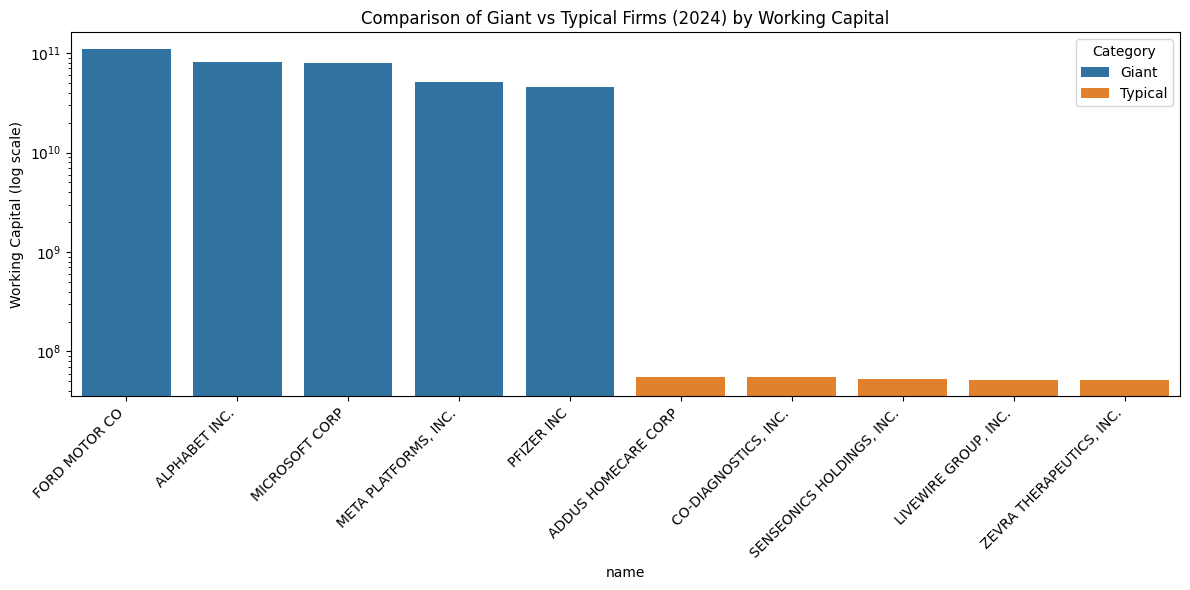

In [23]:
# BarPlot of Giant Firms vs Typical Firms

## Filtering to one year and ensuring non-null values
df_2024 = financials_df[financials_df['filing_year'] == 2024]
df_2024 = df_2024[df_2024['working_capital'].notna()]

## Defining Giant firms vs Typical Firms & Dropping Dulicates
top_firms = df_2024.sort_values('working_capital', ascending=False).drop_duplicates('name').head(5)
median_wc = df_2024['working_capital'].median()
typical_firms = df_2024[
    (df_2024['working_capital'] > median_wc * 0.95) &
    (df_2024['working_capital'] < median_wc * 1.05)
].drop_duplicates('name').sample(5, random_state=1)

## Combine and label + Sorting
compare_df = pd.concat([top_firms, typical_firms])
compare_df['Category'] = ['Giant'] * len(top_firms) + ['Typical'] * len(typical_firms)
compare_df = compare_df.sort_values('working_capital', ascending=False)

## Plot
plt.figure(figsize=(12, 6))
sns.barplot(
    x='name',
    y='working_capital',
    hue='Category',
    data=compare_df,
    dodge=False
)

plt.yscale('log')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Working Capital (log scale)')
plt.title('Comparison of Giant vs Typical Firms (2024) by Working Capital')
plt.tight_layout()
plt.show()


## <u>Conclusion:</u>  

The metrics and outlier checks performed here confirm that no unreasonable or incorrect data remains among the derived financial features. While outliers are present, they are legitimate representations of the industry landscape. As a result, no further action is required on these engineered features, and the dataset is now ready for modeling.

#**Creating the Model**  
The features included in the model were selected based on the value they added during the exploration and cleaning process. The engineered financial ratios were designed to directly assess each firm’s profitability, solvency, and operational standing from year to year.

Flags such as negative_assets_flag, likely_distressed, and likely_data_error were included to help the model detect structurally unusual records and financial inconsistencies.

Additionally, missing data indicators were created for key financial fields. These serve two purposes:

1. They allow the model to recognize when critical financial information is absent—a trait often linked with anomalies.

2. They were necessary for technical reasons, as the Isolation Forest algorithm requires imputed (non-null) input values to function properly.



In [24]:
# Selecting Features for the Model
feature_cols = [
    'debt_to_equity', 'return_on_assets', 'profit_margin',
    'working_capital', 'cash_ratio', 'equity_ratio',
    'negative_assets_flag', 'likely_distressed', 'likely_data_error',
    'revenues_missing', 'stockholders_equity_missing',
    'assets_missing', 'net_income_loss_missing', 'long_term_debt_missing',
    'cashandcashequivalentsatcarryingvalue_missing',
    'assets_current_missing', 'liabilities_current_missing',
    'operating_income_loss_missing'
]

Median imputation was chosen for missing numerical values due to its effectiveness at dealing with outliers and skewed distributions—both of which are common in financial data and present in the `financial_df` for this project. Unlike the mean, the median is not distorted by extreme values, making it a safer and more reliable choice for maintaining the integrity of the dataset when preparing for an Isolation Forest model. This method minimizes the risk of introducing bias while ensuring the algorithm can function without null values.

In [25]:
# Imputing missing values for Isolation Forest
X = financials_df[feature_cols]
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)


## <u> Fitting and Running the Isolation Forest Model</u>  
As this model is exploratory in nature, I opted to use standard baseline thresholds for the number of estimators and the contamination rate in the Isolation Forest model. The advantage of this approach is that it provides a solid starting point for analyzing financial data and yields results within the bounds of what might typically be expected in a dataset of this size. This baseline helps surface potential outliers and allows us to identify firms that may present elevated financial risk.

The model uses 100 estimators — a common default that strikes a balance between computational efficiency and the model's reliability in detecting anomalies. With a dataset of just over 17,000 records, this is a reasonable and defensible choice.

The contamination rate was set to 0.05, which instructs the model to flag approximately 5% of the records as anomalous. This is a pragmatic baseline for exploratory analysis. As I develop a deeper understanding of the dataset, this value can be adjusted to refine the results. A limitation of this method is that I do not know the true proportion of anomalous filings in the data. As a result, the 5% threshold is somewhat speculative — if inaccurate, it may cause the model to over- or under-generalize when flagging potential anomalies.

In [26]:
# Fitting Isolation Forest Model
model = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
model.fit(X_imputed)

IsolationForest(contamination=0.05, random_state=42)

# <b>E: Results & Implications</b>  

To properly assess the model's results, additional rigor was required to ensure it stuck to the parameters highlighted in its design and appropriately captured anomalies in the data.

The code below creates an `anomaly_score` which reflects how isolated and thus unusual a record is, with lower values indicating a higher likelihood of being an anomalous outlier. And `anomaly_flag` was generated by the model's `.predict()` method, labels each record as either an anomaly(-1) or not(1).

The anomaly flag's results were output with total values for each figure, resulting in 862 anomalies. This correlates with approximately 5% of the dataset, which remains consistent with the contamination rate selected when developing the model's parameters.

In [27]:
# Anomaly scores & Anomaly flags
financials_df['anomaly_score'] = model.decision_function(X_imputed)
financials_df['anomaly_flag'] = model.predict(X_imputed)

In [28]:
# Results of Anomaly Flag
financials_df['anomaly_flag'].value_counts()

,count
anomaly_flag,
1,16360
-1,862


Taking an initial look at the top 25 firms flagged with low anomaly scores by the Isolation Forest model, a few specific details become evident immediately.
- Several large-scale firms appeared multiple times, suggesting consistently unusual reporting behavior across years. <i>iShares S&P GSCI Commodity-Indexed Trust</i> and <i>Comerica Inc</i> were flagged repeatedly, indicating that size or structure may contribute to outlier status in these metrics
- Conversely, lesser-known firms such as <i> Yuengling's Ice Cream Corp</i> and <i>Cell Medx Corp.</i> were also present, pointing toward potential financial irregularities or elevated risk profiles.

Anomalies detected in firms of various sizes indicate that the data preparation was adequate in ensuring the model did not stick to only one size or type of firm when identifying anomalous filings.

In [29]:
anomalies = financials_df[financials_df['anomaly_flag'] == -1]
anomalies[['name', 'anomaly_score']].sort_values('anomaly_score').head(25)


,name,anomaly_score
9245,ISHARES S&P GSCI COMMODITY-INDEXED TRUST,-0.132496
2156,LORD ABBETT PRIVATE CREDIT FUND,-0.115364
1175,AT&T INC.,-0.115115
16604,YUENGLINGS ICE CREAM CORP,-0.113736
5050,PRUCO LIFE INSURANCE OF NEW JERSEY,-0.109347
7251,"MUZINICH CORPORATE LENDING INCOME FUND, INC.",-0.106882
7216,ARK 21SHARES BITCOIN ETF,-0.106882
3522,GOLDMAN SACHS PRIVATE CREDIT CORP.,-0.104566
4386,FARMERS NATIONAL BANC CORP /OH/,-0.101443
8258,CELL MEDX CORP.,-0.099885


##<u>Distribution of Anomaly Scores</u>  
Unlike supervised learning models such as linear regression or classification models, Isolation Forest is an unsupervised anomaly detection algorithm. This means there is no specific label for "anomalous" or "normal" for it to compare against. As a result, summary statistics such as p-values, precision, accuracy, F1 scores, and ROC/AUC are not available to assess the model's efficacy. Other methods must be used to analyze these metrics.

The plot below demonstrates a heavily right-skewed distribution of the anomaly scores compared to financial firms' filings. Most scores are between 0.15 and  0.2, indicating "normal" behavior. Additionally, a long left tail is evident, where scores drop below 0, corresponding to the most anomalous entries the model flagged. This separation in the distribution provides strong support for the model's ability to differentiate between typical and atypical financial profiles, consistent with identifying irregularities or risk exposure as described in the research question.

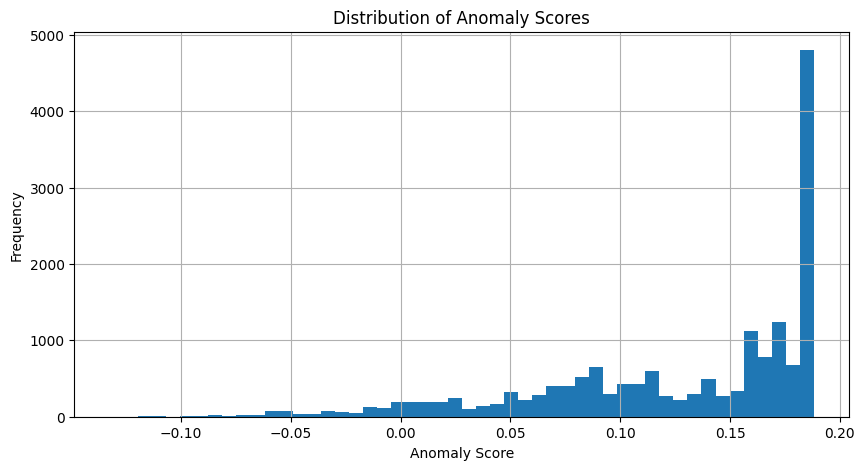

In [32]:
# Plotting Distribution of Anomaly Scores
plt.figure(figsize=(10, 5))
plt.hist(financials_df['anomaly_score'], bins=50)
plt.title('Distribution of Anomaly Scores')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


## <u> Comparison to Firms Dropped in 2024</u>  
A crosstab analysis compared the model's flagged anomalies with firms that ceased filing in 2024. Of the 862 filings labeled anomalous by the model, only 92 (10.7%) dropped out, compared to 2,646 of the 16,360 regular filings (16.2%). This result suggests that the Isolation Forest algorithm effectively identified statistical outliers, but these outliers did not necessarily align with firms at immediate risk of disappearance. Instead, the model may identify entities with structural or reporting irregularities rather than those with financial distress.

In [30]:
# Crosstab analysis of Anomalous filings to Firms Dropped in 2024
pd.crosstab(financials_df['anomaly_flag'], financials_df['dropped_in_2024'], margins=True)


dropped_in_2024,False,True,All
anomaly_flag,,,
-1,770,92,862
1,13714,2646,16360
All,14484,2738,17222


### <u> Chi-Square test</u>  
A Chi-square test was conducted on the results to analyze the cross-tab analysis further. Critically, the x<sup>2</sup> value was returned as 18.1 a huge Chi-Square statistic, and the p-value for the test was 2.07 x 10<sup>5</sup> - well below the 0.05 baseline p-value threshold. These values indicate a statistically significant association between whether a firm was flagged as an anomaly and whether it dropped out in 2024.

With that said, the direction of the relationship was somewhat unexpected - flagged anomalies were less likely to drop out in 2024 than the predicted dropout rate (92 instead of 137). This may suggest that the model identified firms with statistically irregular filings, but these anomalies may not correspond directly with short-term disappearance, but rather reporting irregularities or other deviations that would persist even among firms that continued to file.

In [35]:
# Creating a Chi-Square test to test the validity of the Cross-Tab
contingency_table = pd.DataFrame({
    'Dropped_2024_True': [92, 2646],
    'Dropped_2024_False': [770, 13714]
}, index=['Anomaly (-1)', 'Normal (1)'])

## Running the Chi Square Test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Chi-Square Statistic:", chi2)
print("Degrees of Freedom:", dof)
print("P-Value:", p)
print("\nExpected Frequencies Table:")
print(pd.DataFrame(expected, index=contingency_table.index, columns=contingency_table.columns))

Chi-Square Statistic: 18.121694442266737
Degrees of Freedom: 1
P-Value: 2.0722693729815352e-05

Expected Frequencies Table:
              Dropped_2024_True  Dropped_2024_False
Anomaly (-1)         137.043084          724.956916
Normal (1)          2600.956916        13759.043084


##<u>Analysis of 10 most anomalous firms</u>  

The firms with the highest anomaly scores were reviewed for financial irregularity, risk, or reporting issues to explore the most extreme statistical outliers identified by the Isolation Forest model. Several of these firms indicated signs of distress, such as <i> Yuengling's Ice Cream Corp</i> which had a return on assets of -24,067% and, dropped out of SEC reporting in 2024. Others, such as <i>Farmers National Bancorp</i>, exhibited completely implausible debt ratios, suggesting corrupted data or true anomaly reporting. Conversely,  multiple Exchange Trade Funds (ETFs) or private credit funds such as <i>ISHARES</i> and <i>Lord Abbett</i> reported incomplete or unusual financial data, resulting in unusually high equity or profit margins while entire rows of data were missing. Further still, multiple firms returned completely blank values for all of the financial metrics generated, suggesting significant gaps in reporting for values.

In [33]:
# Show top 10 most anomalous firms with financial ratios and dropout status
top_anomalies = financials_df[financials_df['anomaly_flag'] == -1]
top_anomalies = top_anomalies.sort_values('anomaly_score').head(10)

cols = ['name', 'filing_year', 'anomaly_score', 'dropped_in_2024',
        'debt_to_equity', 'return_on_assets', 'profit_margin', 'equity_ratio']
top_anomalies[cols]


,name,filing_year,anomaly_score,dropped_in_2024,debt_to_equity,return_on_assets,profit_margin,equity_ratio
9245,ISHARES S&P GSCI COMMODITY-INDEXED TRUST,2023,-0.132496,False,NaN,NaN,859.107388,NaN
2156,LORD ABBETT PRIVATE CREDIT FUND,2024,-0.115364,False,NaN,NaN,NaN,NaN
1175,AT&T INC.,2023,-0.115115,False,NaN,-0.187015,-105.882353,NaN
16604,YUENGLINGS ICE CREAM CORP,2023,-0.113736,True,-4.430078e-01,-24067.600000,-24067.600000,-2.228078e+05
5050,PRUCO LIFE INSURANCE OF NEW JERSEY,2024,-0.109347,False,2.042799e-01,NaN,NaN,-1.128554e+02
7251,"MUZINICH CORPORATE LENDING INCOME FUND, INC.",2023,-0.106882,False,NaN,NaN,NaN,NaN
7216,ARK 21SHARES BITCOIN ETF,2023,-0.106882,False,NaN,NaN,NaN,NaN
3522,GOLDMAN SACHS PRIVATE CREDIT CORP.,2023,-0.104566,False,1.980486e-01,NaN,NaN,1.590837e+06
4386,FARMERS NATIONAL BANC CORP /OH/,2024,-0.101443,False,-2.336968e+06,-18.877883,NaN,7.561437e-04
8258,CELL MEDX CORP.,2022,-0.099885,False,NaN,NaN,NaN,NaN


##<b>Implications and Recommendations</b>

The research question guiding this project was: <i>“Can unsupervised machine learning identify anomalous patterns in standardized financial filings that may indicate potential financial irregularity, risk exposure, or reporting inconsistencies?”</i>

By applying an Isolation Forest model to three years of SEC financial statement data, I successfully generated anomaly scores and identified firms whose financial profiles deviated significantly from their peers. These included firms with indicators of financial distress—such as extremely negative returns or implausible debt ratios—as well as entities whose filings reflected structural or reporting inconsistencies, such as missing key financial metrics. To evaluate real-world risk exposure, a dropout indicator was used to track which firms failed to file in the final year, offering an additional lens into potential instability.

These results support the underlying theory that unsupervised machine learning can reveal statistically anomalous patterns that may correlate with risk or irregularity. While the model alone does not diagnose fraud or failure, it can serve as a valuable signal for further investigation.

One key limitation of this approach is that the Isolation Forest model requires numeric or binary input. This excludes textual disclosures, qualitative statements, and other contextual information that may be vital to a complete risk assessment. Disclosures in particular are a glaring component missing from analysis, as they can provide direct detail on how firms are not remaining in compliance with rules.
<br><br>

<u>Recommended Course of Action</u>  
Based on these findings, investors, analysts, and regulatory bodies could use a modified version of this model as a screening tool. It could help prioritize which firms warrant further financial review, audit attention, or risk analysis. For example, regulatory agencies who have additional processing power or capabilities could train the model on quarterly 10-Q filings to detect inconsistent or erratic reporting patterns over time. Alternatively, investors could integrate anomaly scores into their due diligence processes to identify red flags before acquiring or investing in a firm.
<br><br>

<u>Future Study of the Dataset</u>  
- Expand Dataset Scope: Incorporating quarterly filings or additional historical years would increase variance, potentially uncovering emerging or recurring patterns of anomalous behavior, particularly in firms who demonstrate similar patterns year-over-year. Expanding the analysis window would also help validate whether flagged anomalies persist or evolve over time.

- Enhance Model Inputs: Integrating natural language processing (NLP) techniques alongside the numeric model would allow the system to capture risk-relevant narrative disclosures (e.g., auditor concerns, legal proceedings, management commentary) that are excluded from purely quantitative analysis. This would greatly improve the robustness of the model and potentially uncover additional insights.


#<b>F. Sources & Citations</b>

- U.S. Securities and Exchange Commission. (n.d.). SEC financial statement data sets. SEC.gov. https://www.sec.gov/data-research/sec-markets-data/financial-statement-data-sets

- user12929183. (2020, March 5). Jupyter Notebook: How to leave one cell out while "Run All" [Online forum post]. Stack Overflow. https://stackoverflow.com/questions/60556163/jupyter-notebook-how-to-leave-one-cell-out-while-run-all

- Peter Mortensen. (2012, January 19). How can I print bold text in Python? [Online forum post]. Stack Overflow. https://stackoverflow.com/questions/8924173/how-can-i-print-bold-text-in-python